In [1]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

In [3]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [4]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


In [5]:
start_symbol = '_START_'
end_symbol = '_END_'

for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["_START_"]+sentence.split(' ')+["_END_"]

In [6]:
from collections import Counter
word_counts = Counter()

for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        for word in captions[img_i][caption_i][1:-1]:
            word_counts[word] += 1
            
x = 5

unknown_symbol = '_UNK_'
padding_symbol = '_PAD_'

vocab  = [unknown_symbol, start_symbol, end_symbol, padding_symbol]
vocab += [k for k, v in word_counts.items() if v >= x if k not in vocab]
n_tokens = len(vocab)

In [7]:
word_to_index = {w: i for i, w in enumerate(vocab)}

In [8]:
eos_ix = word_to_index[end_symbol]
unk_ix = word_to_index[unknown_symbol]
pad_ix = word_to_index[padding_symbol]

def word_to_matrix(sequences, max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.ones((len(sequences), max_len), dtype='int32') * pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [10]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        super(self.__class__, self).__init__()
        
        # два линейных слоя, которые будут из векторов, полученных на выходе Inseption, 
        # получать начальные состояния h0 и c0 LSTM-ки, которую мы потом будем 
        # разворачивать во времени и генерить ею текст
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units).to(device)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units).to(device)
        
        # вот теперь recurrent part

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, 64, padding_idx = pad_ix).to(device)
            
        # lstm: настакайте LSTM-ок (1 или более, но не надо сразу пихать больше двух, замечаетесь ждать).
        self.lstm = nn.LSTM(batch_first = True, input_size = 64, hidden_size = lstm_units).to(device)
#         self.lstm2 = nn.LSTM(batch_first = True, input_size = 256, hidden_size = lstm_units).to(device)
            
        # ну и линейный слой для получения логитов
        self.logits = nn.Linear(lstm_units, n_tokens).to(device)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # 
        captions_emb = self.emb(captions_ix)
        
        # применим LSTM:
        # 1. инициализируем lstm state с помощью initial_* (сверху)
        # 2. скормим LSTM captions_emb
        # 3. посчитаем логиты из выхода LSTM
        
        
        lstm_out, (cell_next, hid_next) = self.lstm(captions_emb, (initial_cell[None], initial_hid[None])) # shape: [batch, caption_length, lstm_units]
#         lstm_out, (cell_next, hid_next) = self.lstm2(lstm_out, (cell_next, hid_next)) # shape: [batch, caption_length, lstm_units]
        
       
        logits = self.logits(lstm_out)
        
        return logits        

In [11]:
network = torch.load('model100ep384bs.pkl')
network.eval()

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or s

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (emb): Embedding(10403, 64, padding_idx=3)
  (lstm): LSTM(64, 256, batch_first=True)
  (logits): Linear(in_features=256, out_features=10403, bias=True)
)

In [12]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

In [13]:
def generate_caption(image, caption_prefix=("_START_",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)
        
        vectors_neck = vectors_neck.to(device)

        for _ in range(max_len):
            # представить в виде матрицы
            prefix_ix = word_to_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).to(device)
            # получаем логиты из RNN-ки
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            # переводим их в вероятности
            next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # опционально

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            # RNN-ка сгенерила символ конца предложения, расходимся
            if next_word == "_END_":
                break
            
    return caption_prefix

In [19]:
from matplotlib import pyplot as plt
from PIL import Image
# from scipy.misc import imresize
%matplotlib inline

#sample image
#!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
# img = imresize(img, (299, 299)).astype('float32') / 255.
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

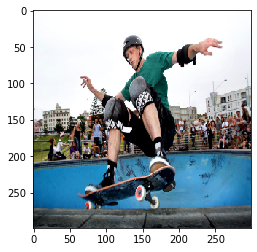

In [20]:
plt.imshow(img)

In [21]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a skateboarder is about to go down a ramp .
a skateboarder is doing a trick in the air .
a man riding a skateboard up the side of a ramp .
a skateboarder is balancing on the rim of a bowl .
a skateboarder is doing a trick on a ramp .
a skateboarder is doing a trick on a rail .
a skateboarder is in mid air on a ramp .
a skateboarder is jumping over a rail .
a man riding a skateboard up the side of a ramp .
a young man riding a skateboard up a ramp .
